In [1]:
import os 
cwd = os.getcwd()

os.chdir('../')
cwd = os.getcwd()
print(cwd)

os.chdir('./code/')
cwd = os.getcwd()
print(cwd)

import pandas as pd 
import numpy as np 
import seaborn as sns

import pickle 
import logging


# from config.config import SQLQuery
# querySno = SQLQuery('snowflake')

/Users/shashankgupta/Documents/code/git_project/plaid_credit
/Users/shashankgupta/Documents/code/git_project/plaid_credit/Code


In [2]:
from preprocess import Convert,MissingValues,Outlier,FeatureSelection
from feature_transformation import Scaler,Transform,Selection
from model_building import split_test_train, feature_encoding, classification_models
from model_evaluations import model_metrics, feature_importance, probability_bins, cross_validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

from statsmodels.stats.outliers_influence import variance_inflation_factor

# object initiation 
tf = Transform()
sel = Selection()
ft = FeatureSelection()
cv = Convert()
mv = MissingValues()
ot = Outlier()

# set seed
seed = 9

In [3]:
corr_arr = 0.4 # person correlation coefficient # change it to 0.5
vif_arr = 5 # vif coefficient
features_arr = 10 # total number of features to be selected from backward feature selection
iv_upper_limit = 0.5 # upper threshold of iv # change it to 0.6
iv_lower_limit = 0.02 # lower threshold of iv

In [23]:
df_raw = pd.read_pickle('/Users/shashankgupta/Documents/code/git_project/plaid_credit/data/final_dataset_2.pkl')
df_raw.shape

(646, 255)

In [24]:
# excluding stddev features
keep_stddev_cols = ['stddev_credit_amt_3M']
stddev_cols = list(df_raw.loc[:,df_raw.columns.str.contains('stddev')].columns)

keep_cols = list(set(list(df_raw.columns)).difference(set(stddev_cols))) + keep_stddev_cols


df_raw = df_raw[keep_cols]
df_raw.shape

(646, 219)

In [6]:
df_raw['txn_flag'].value_counts()

txn_flag
1.0    637
0.0      9
Name: count, dtype: int64

In [7]:
df_raw = df_raw[df_raw['txn_flag']==1]
df_raw.shape

(637, 218)

In [8]:
df_raw = df_raw.drop(['business_id', 'lending_business_id','decision_date','drawn_flag', 'everDPD_15', 'fico_score','txn_flag'], axis=1)
df_raw.shape

(637, 211)

In [9]:
## train-test split

# train test split
x_train, y_train, x_test, y_test = split_test_train(df_raw, target_column='target', test_size=0.3, random_state=seed)
print(f'{x_train.shape = }', '|' ,f'{y_train.shape = }', '|' ,f'{x_test.shape = }', '|' ,f'{y_test.shape = }')


# copy to df
df = x_train.copy(deep=True)

x_train.shape = (445, 210) | y_train.shape = (445,) | x_test.shape = (192, 210) | y_test.shape = (192,)


In [10]:
# get constant features
def get_const_features(df):
    const_list = []
    for col in df.columns: 
        if (len(df[col].unique())==1):
            const_list.append(col)
    return(const_list)

# remove constant features
const_list = get_const_features(df)
df = df.drop(columns=const_list)
df.shape

(445, 210)

In [11]:
# get quasi-constant features
def get_quasi_const_features(df, threshold=0.01):
    qconst_list = []
    for col in df.columns: 
        if (df[col].var() <= threshold):
            qconst_list.append(col)
    return(qconst_list)

# remove constant features
qconst_list = get_quasi_const_features(df, threshold=0.01)
df = df.drop(columns=qconst_list)
df.shape

(445, 201)

In [12]:
# view missing values
def missing_value(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_val_df = pd.DataFrame({'percent_missing': percent_missing})
    missing_val_df.sort_values(by='percent_missing', ascending=False, inplace=True)
    return missing_val_df

missing_value(df)

,percent_missing
loans_amt_1M,91.011236
ratio_loans_size_credit_size_1M,91.011236
loans_count_1M,91.011236
median_loans_amt_1M,91.011236
ratio_loan_size_1M_3M,91.011236
...,...
third_party_flag,0.000000
ecom_flag,0.000000
pos_flag,0.000000
txn_each_mth_flag,0.000000


In [13]:
t = missing_value(df)
drop_cols = list(t[t['percent_missing']>80].index)
df.drop(drop_cols,axis=1,inplace=True)
df.shape

(445, 174)

In [14]:
# Treating missing values
df = df.fillna(0)

In [15]:
# get boolean columns
def findbool(df):
    bool_arr = []
    for col in df.columns: 
        if (len(df[col].unique())<=2):
            bool_arr.append(col)
    return(bool_arr)

# get datatypes frequency
def get_datatypes_freq(df):
    type_dct = {str(k): list(v) for k, v in df.groupby(df.dtypes, axis=1)}
    type_dct_info = {k: len(v) for k, v in type_dct.items()}
    return type_dct, type_dct_info

type_dct, type_dct_info = get_datatypes_freq(df)
print(type_dct_info)

bool_col_list = findbool(df)
print(len(bool_col_list))

type_dct, type_dct_info = get_datatypes_freq(df)
col_list = (type_dct['float64'])
col_list_excpt_bool = [column for column in col_list if column not in bool_col_list]
print(len(col_list_excpt_bool))

{'float64': 174}
10
164


In [16]:
## iv_woe

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [17]:
# remove features on basis of IV
# y_train.reset_index(drop=True, inplace=True)
df['target'] = y_train
df['target'] = df['target'].astype(float)
temp = df.copy()

t1, t2 = iv_woe(temp[np.append(col_list_excpt_bool,['target'])], 'target', bins=5, show_woe=False)
feature_list = list(t1[ (t1['IV']<iv_upper_limit) & (t1['IV']>iv_lower_limit) ]['Variable'].values)
len(feature_list)

Information value of total_credit_count_1M is 0.046417
Information value of total_credit_count_3M is 0.123842
Information value of total_credit_count_6M is 0.106814
Information value of total_credit_amt_1M is 0.039476
Information value of total_credit_amt_3M is 0.087181
Information value of total_credit_amt_6M is 0.046794
Information value of credit_size_1M is 0.117904
Information value of credit_size_3M is 0.286985
Information value of credit_size_6M is 0.244407
Information value of median_credit_amt_1M is 0.14747
Information value of median_credit_amt_3M is 0.195674
Information value of median_credit_amt_6M is 0.254997
Information value of ratio_median_credit_amt_1M_6M is 0.056231
Information value of ratio_median_credit_amt_1M_3M is 0.05263
Information value of loans_amt_6M is 0.023398
Information value of loans_count_6M is 0.034076
Information value of median_loans_amt_6M is 0.023398
Information value of payroll_amt_6M is 0.024865
Information value of payroll_count_6M is 0.005915
I

124

In [18]:
# view correlation
corr_df, subset_df = sel.get_correlated_features(df, feature_list, thresh=corr_arr)
corr_df


# remove correlated features
feature_list = sel.corr_iter(df, np.array(feature_list), thresh=corr_arr)
feature_list = list(feature_list)
len(feature_list)

26

In [19]:
# get feature list after iterative VIF elimination
def vif_iter(df, iv, threshold=10):
    vif_data = pd.DataFrame()
    vif_data["feature"] = iv
    vif_data["VIF"] = [variance_inflation_factor(df[iv].values, i) for i in range(len(iv))]
    if len(vif_data[vif_data['VIF'] == np.inf]) > 0:
        feature = vif_data[vif_data['VIF'] == np.inf]['feature'].iloc[0]
        iv.remove(feature)
        vif_iter(df, iv, threshold)
    elif len(vif_data[vif_data['VIF'] > threshold]) > 0:
        feature = vif_data.sort_values(by='VIF', ascending=False)['feature'].iloc[0]
        iv.remove(feature)
        vif_iter(df, iv, threshold)
    vif_data = pd.DataFrame()
    vif_data["feature"] = iv
    vif_data["VIF"] = [variance_inflation_factor(df[iv].values, i) for i in range(len(iv))]
    return iv, vif_data

feature_list, vif_df = vif_iter(df, feature_list, threshold=vif_arr)
len(feature_list)

26

In [20]:
# Backward feature elimination
feat_list = ft.backward_feature_selection(df[feature_list], y_train, num_features=features_arr)
feat_list

['median_credit_amt_6M',
 'loans_count_6M',
 'pos_count_3M',
 'median_third_party_amt_3M',
 'ratio_median_third_party_amt_3M_6M',
 'ratio_pos_size_credit_size_1M',
 'ratio_shops_size_credit_size_3M',
 'sum_credits_grt_500_6M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'ratio_amt_credits_grt_500_credits_grt_1500_6M']

In [21]:
## optimal binning woe

import optbinning as optb
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.binning.binning_statistics import BinningTable

df_temp = df[feat_list].copy()
df_temp['target'] = df['target']

(CVXPY) Jun 30 04:31:28 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 30 04:31:28 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


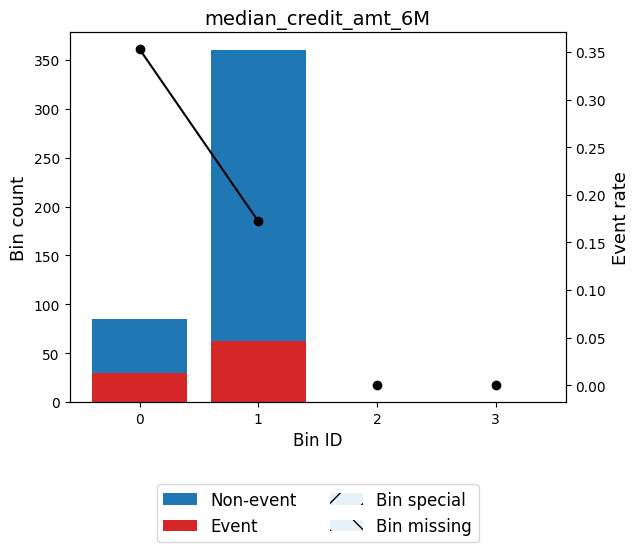

In [73]:
# 1
Xt= df_temp['median_credit_amt_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_credit_amt_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_credit_amt_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [74]:
ob_median_credit_amt_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 112.50)",85,0.191011,55,30,0.352941,-0.738544,0.125759,0.015372
1,"[112.50, inf)",360,0.808989,298,62,0.172222,0.22528,0.038361,0.004785
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.164119,0.020157


In [24]:
# 1
# Var tranform
transformed_vars = df[feat_list].copy()

# transform
col         = 'median_credit_amt_6M'
conditions  = [ transformed_vars[col] < 112.5,
                transformed_vars[col] >= 112.5 ]

choices     = [-0.738544,0.22528]
    
transformed_vars["median_credit_amt_6M"] = np.select(conditions, choices, default=np.nan)

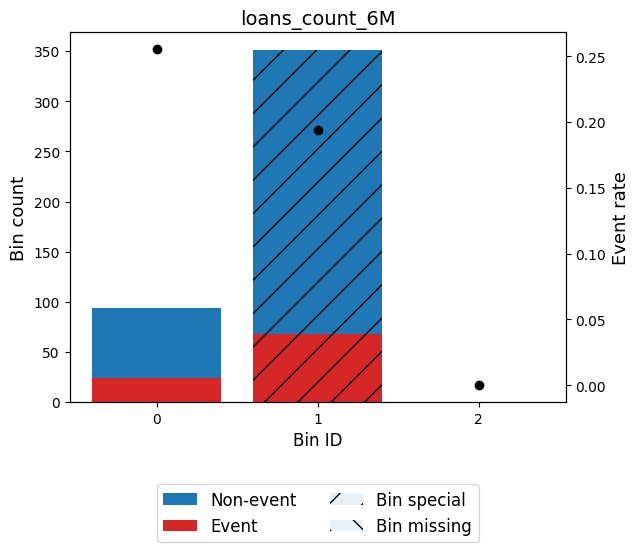

In [25]:
# 2
Xt= df_temp['loans_count_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='loans_count_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_loans_count_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [26]:
ob_loans_count_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",94,0.211236,70,24,0.255319,-0.274238,0.017159,0.002138
1,Special,351,0.788764,283,68,0.193732,0.08126,0.005084,0.000635
2,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.022243,0.002774


In [27]:
# 2
# transform
col         = 'loans_count_6M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [0.08126,-0.274238]
    
transformed_vars["loans_count_6M"] = np.select(conditions, choices, default=np.nan)

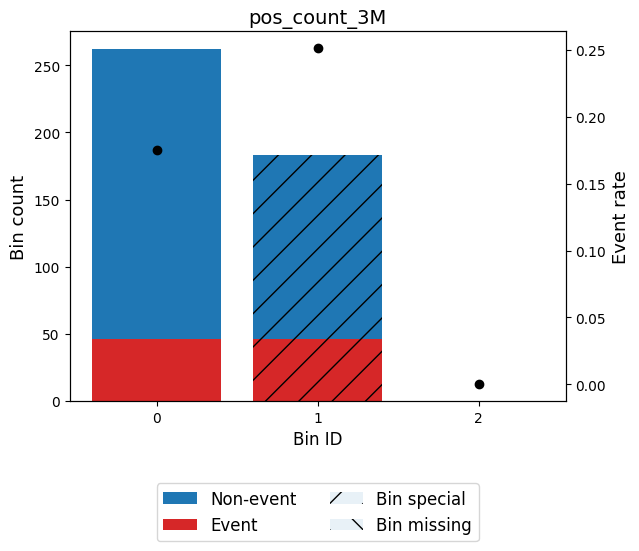

In [28]:
# 3
Xt= df_temp['pos_count_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='pos_count_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_pos_count_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [29]:
ob_pos_count_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",262,0.588764,216,46,0.175573,0.201958,0.022599,0.002820
1,Special,183,0.411236,137,46,0.251366,-0.25334,0.028348,0.003534
2,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.050947,0.006354


In [30]:
# 3
# transform
col         = 'pos_count_3M'
conditions  = [ transformed_vars[col] <= 0, 
                transformed_vars[col] > 0 ]

choices     = [-0.25334,0.201958]
    
transformed_vars["pos_count_3M"] = np.select(conditions, choices, default=np.nan)

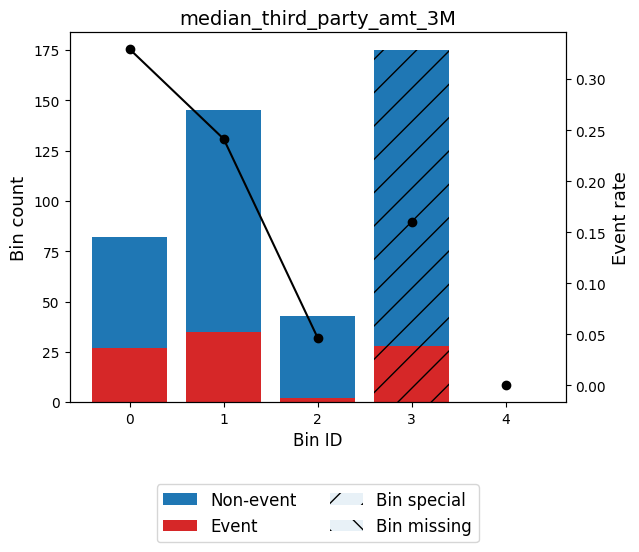

In [31]:
# 4
Xt= df_temp['median_third_party_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_third_party_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_third_party_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [32]:
ob_median_third_party_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 99.12)",82,0.184270,55,27,0.329268,-0.633183,0.087171,0.010718
1,"[99.12, 1092.00)",145,0.325843,110,35,0.241379,-0.199547,0.013733,0.001714
2,"[1092.00, inf)",43,0.096629,41,2,0.046512,1.675745,0.158204,0.017745
3,Special,175,0.393258,147,28,0.160000,0.313549,0.035143,0.004375
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.294251,0.034551


In [33]:
# 4
# transform
col         = 'median_third_party_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 99.12),
                (transformed_vars[col] >= 99.12 ) & (transformed_vars[col] < 1092),
                transformed_vars[col] >= 1092 ]

choices     = [0.313549,-0.633183,-0.199547,1.675745]
    
transformed_vars["median_third_party_amt_3M"] = np.select(conditions, choices, default=np.nan)

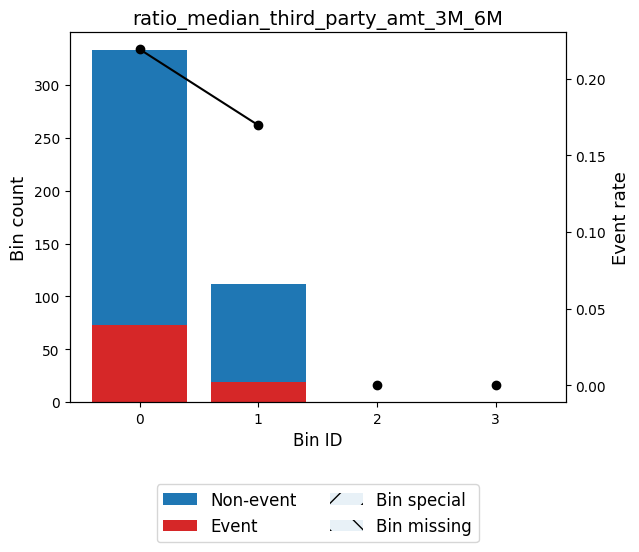

In [34]:
# 5
Xt= df_temp['ratio_median_third_party_amt_3M_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_median_third_party_amt_3M_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_median_third_party_amt_3M_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [35]:
ob_ratio_median_third_party_amt_3M_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.00)",333,0.748315,260,73,0.219219,-0.074457,0.004239,0.000530
1,"[1.00, inf)",112,0.251685,93,19,0.169643,0.243481,0.013862,0.001729
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.018102,0.002258


In [36]:
# 5
# transform
col         = 'ratio_median_third_party_amt_3M_6M'
conditions  = [ transformed_vars[col] < 1,
                transformed_vars[col] >= 1]

choices     = [-0.074457,0.243481]
    
transformed_vars["ratio_median_third_party_amt_3M_6M"] = np.select(conditions, choices, default=np.nan)

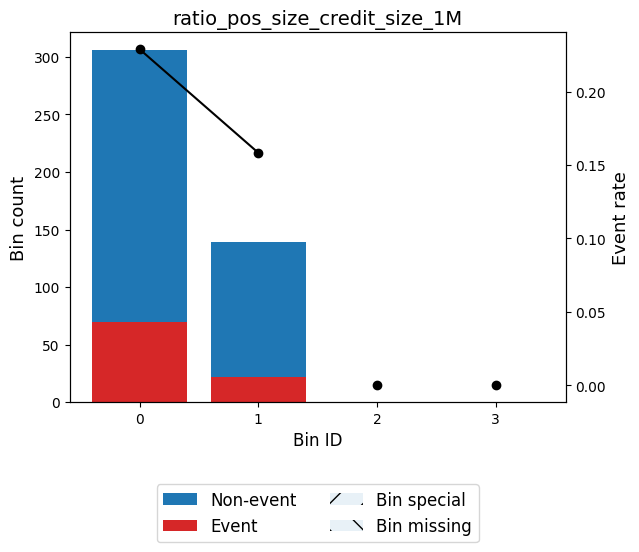

In [37]:
# 6
Xt= df_temp['ratio_pos_size_credit_size_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_pos_size_credit_size_1M', dtype="numerical", max_n_prebins=2, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_pos_size_credit_size_1M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [38]:
ob_ratio_pos_size_credit_size_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.27)",306,0.68764,236,70,0.228758,-0.129343,0.011940,0.001491
1,"[0.27, inf)",139,0.31236,117,22,0.158273,0.326452,0.030136,0.003750
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.00000,353,92,0.206742,,0.042076,0.005242


In [39]:
# 6
# transform
col         = 'ratio_pos_size_credit_size_1M'
conditions  = [ transformed_vars[col] < 0.27,
                transformed_vars[col] >= 0.27 ]

choices     = [-0.129343,0.326452]
    
transformed_vars["ratio_pos_size_credit_size_1M"] = np.select(conditions, choices, default=np.nan)

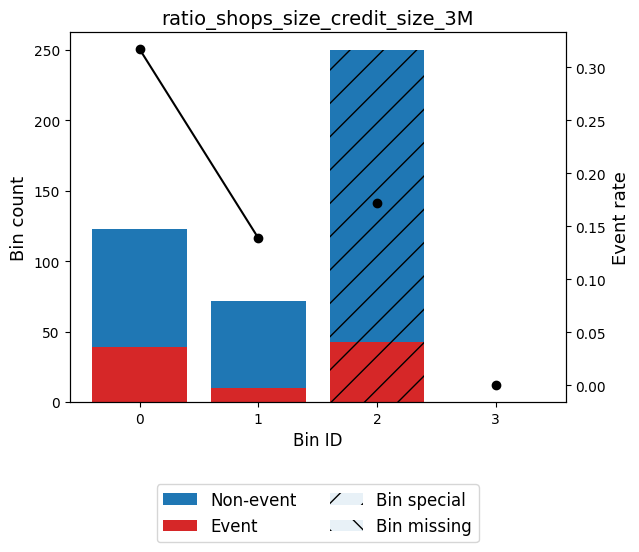

In [40]:
# 7
Xt= df_temp['ratio_shops_size_credit_size_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_shops_size_credit_size_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_shops_size_credit_size_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [41]:
ob_ratio_shops_size_credit_size_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.86)",123,0.276404,84,39,0.317073,-0.577424,0.107374,0.013238
1,"[0.86, inf)",72,0.161798,62,10,0.138889,0.47987,0.032123,0.003977
2,Special,250,0.561798,207,43,0.172000,0.226839,0.026996,0.003367
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.166493,0.020583


In [42]:
# 7
# transform
col         = 'ratio_shops_size_credit_size_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 0.86),
                transformed_vars[col] >= 0.86 ]

choices     = [0.226839,-0.577424,0.47987]
    
transformed_vars["ratio_shops_size_credit_size_3M"] = np.select(conditions, choices, default=np.nan)

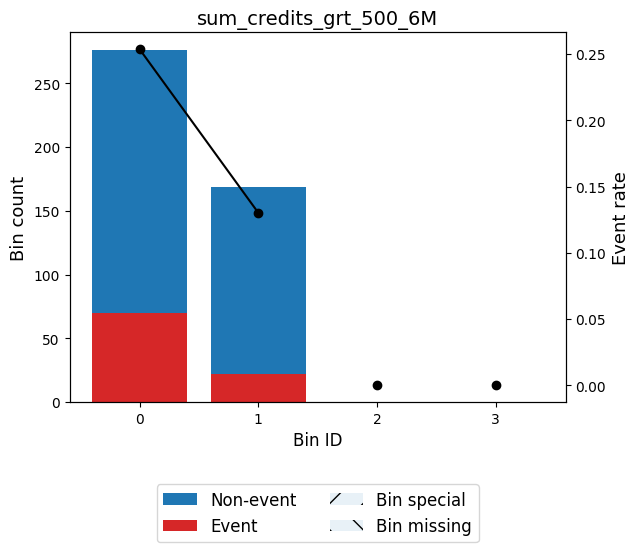

In [43]:
# 8
Xt= df_temp['sum_credits_grt_500_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='sum_credits_grt_500_6M', dtype="numerical", max_n_prebins=2, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_sum_credits_grt_500_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [44]:
ob_sum_credits_grt_500_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 53973.49)",276,0.620225,206,70,0.253623,-0.265299,0.047037,0.005863
1,"[53973.49, inf)",169,0.379775,147,22,0.130178,0.554711,0.098350,0.012139
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.145388,0.018001


In [45]:
# 8
# transform
col         = 'sum_credits_grt_500_6M'
conditions  = [ transformed_vars[col] < 53973.5,
                transformed_vars[col] >= 53973.5 ]

choices     = [-0.265299,0.554711]
    
transformed_vars["sum_credits_grt_500_6M"] = np.select(conditions, choices, default=np.nan)

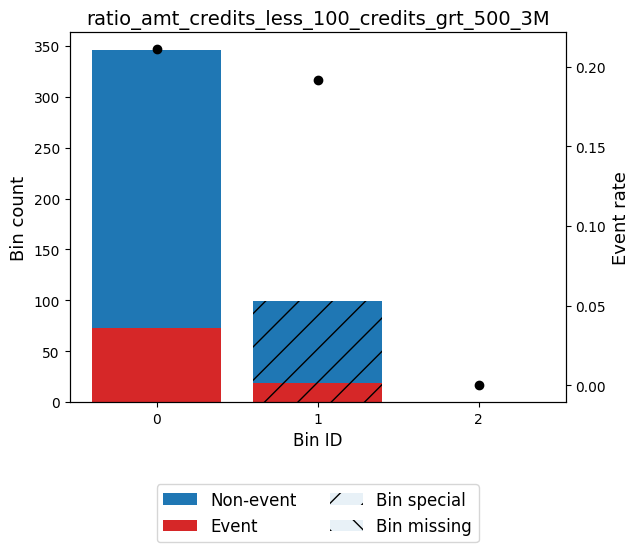

In [69]:
# 9
Xt= df_temp['ratio_amt_credits_less_100_credits_grt_500_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_amt_credits_less_100_credits_grt_500_3M', dtype="numerical", max_n_prebins=2, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_amt_credits_less_100_credits_grt_500_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [70]:
ob_ratio_amt_credits_less_100_credits_grt_500_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",346,0.777528,273,73,0.210983,-0.025667,0.000516,0.000065
1,Special,99,0.222472,80,19,0.191919,0.092908,0.001868,0.000233
2,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.002384,0.000298


In [48]:
# 9
# transform
col         = 'ratio_amt_credits_less_100_credits_grt_500_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [0.092908,-0.025667]
    
transformed_vars["ratio_amt_credits_less_100_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

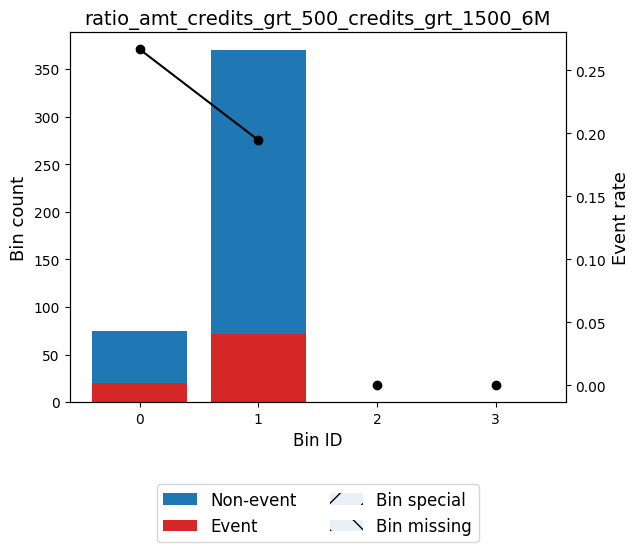

In [49]:
# 10
Xt= df_temp['ratio_amt_credits_grt_500_credits_grt_1500_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_amt_credits_grt_500_credits_grt_1500_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_amt_credits_grt_500_credits_grt_1500_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [50]:
ob_ratio_amt_credits_grt_500_credits_grt_1500_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.00)",75,0.168539,55,20,0.266667,-0.333079,0.020512,0.002552
1,"[1.00, inf)",370,0.831461,298,72,0.194595,0.075748,0.004665,0.000583
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.025177,0.003135


In [51]:
# 10
# transform
col         = 'ratio_amt_credits_grt_500_credits_grt_1500_6M'
conditions  = [ transformed_vars[col] < 1,
                transformed_vars[col] >= 1 ]

choices     = [-0.333079,0.075748]
    
transformed_vars["ratio_amt_credits_grt_500_credits_grt_1500_6M"] = np.select(conditions, choices, default=np.nan)

In [52]:
transformed_vars

,median_credit_amt_6M,loans_count_6M,pos_count_3M,median_third_party_amt_3M,ratio_median_third_party_amt_3M_6M,ratio_pos_size_credit_size_1M,ratio_shops_size_credit_size_3M,sum_credits_grt_500_6M,ratio_amt_credits_less_100_credits_grt_500_3M,ratio_amt_credits_grt_500_credits_grt_1500_6M
408,0.225280,0.081260,0.201958,0.313549,-0.074457,-0.129343,0.226839,-0.265299,0.092908,-0.333079
108,0.225280,0.081260,0.201958,-0.633183,-0.074457,-0.129343,-0.577424,-0.265299,-0.025667,0.075748
613,-0.738544,0.081260,-0.253340,-0.633183,-0.074457,-0.129343,0.226839,-0.265299,-0.025667,0.075748
101,-0.738544,0.081260,0.201958,-0.633183,-0.074457,0.326452,-0.577424,-0.265299,-0.025667,0.075748
484,0.225280,-0.274238,-0.253340,-0.199547,-0.074457,-0.129343,0.226839,0.554711,0.092908,0.075748
...,...,...,...,...,...,...,...,...,...,...
170,0.225280,0.081260,0.201958,-0.199547,0.243481,-0.129343,-0.577424,-0.265299,-0.025667,0.075748
157,0.225280,0.081260,0.201958,-0.633183,-0.074457,-0.129343,-0.577424,0.554711,-0.025667,0.075748
36,0.225280,-0.274238,-0.253340,0.313549,-0.074457,-0.129343,0.226839,-0.265299,-0.025667,0.075748
5,-0.738544,-0.274238,0.201958,-0.633183,-0.074457,-0.129343,-0.577424,-0.265299,-0.025667,0.075748


#### Model fitting

In [53]:
# copy vars
X_train = transformed_vars.copy()

# hyperparameters
params_log_reg = {'penalty': 'l2',
                  'random_state': seed,
                  'solver': 'liblinear',
                  'class_weight': 'balanced'}

# model fit
logreg_model = classification_models(X_train[feat_list], y_train, params_log_reg, models=['log_reg'])

In [54]:
# train cv scores
cv_scores = cross_validation(logreg_model, X_train[feat_list], y_train, scoring='roc_auc', folds=3, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.74 0.74 0.62]
Mean of CV Scores - 0.7


In [55]:
# Feature importance
feat_imp = feature_importance(logreg_model, X_train[feat_list], show_plot=True)

feat_imp.sort_values(by='importance', ascending=False)

,importance
ratio_median_third_party_amt_3M_6M,0.086389
ratio_amt_credits_grt_500_credits_grt_1500_6M,0.013271
ratio_amt_credits_less_100_credits_grt_500_3M,-0.093845
median_credit_amt_6M,-0.513703
ratio_pos_size_credit_size_1M,-0.602615
sum_credits_grt_500_6M,-0.710947
loans_count_6M,-0.840520
ratio_shops_size_credit_size_3M,-0.990075
median_third_party_amt_3M,-1.004986
pos_count_3M,-1.293938


In [56]:
# binning variable transform
x_test.fillna(0, inplace=True)

transformed_vars = x_test[feat_list]

In [57]:
# 1
# transform
col         = 'median_credit_amt_6M'
conditions  = [ transformed_vars[col] < 112.5,
                transformed_vars[col] >= 112.5 ]

choices     = [-0.738544,0.22528]
    
transformed_vars["median_credit_amt_6M"] = np.select(conditions, choices, default=np.nan)

# 2
# transform
col         = 'loans_count_6M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [0.08126,-0.274238]
    
transformed_vars["loans_count_6M"] = np.select(conditions, choices, default=np.nan)

# 3
# transform
col         = 'pos_count_3M'
conditions  = [ transformed_vars[col] <= 0, 
                transformed_vars[col] > 0 ]

choices     = [-0.25334,0.201958]
    
transformed_vars["pos_count_3M"] = np.select(conditions, choices, default=np.nan)

# 4
# transform
col         = 'median_third_party_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 99.12),
                (transformed_vars[col] >= 99.12 ) & (transformed_vars[col] < 1092),
                transformed_vars[col] >= 1092 ]

choices     = [0.313549,-0.633183,-0.199547,1.675745]
    
transformed_vars["median_third_party_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 5
# transform
col         = 'ratio_median_third_party_amt_3M_6M'
conditions  = [ transformed_vars[col] < 1,
                transformed_vars[col] >= 1]

choices     = [-0.074457,0.243481]
    
transformed_vars["ratio_median_third_party_amt_3M_6M"] = np.select(conditions, choices, default=np.nan)

# 6
# transform
col         = 'ratio_pos_size_credit_size_1M'
conditions  = [ transformed_vars[col] < 0.27,
                transformed_vars[col] >= 0.27 ]

choices     = [-0.129343,0.326452]
    
transformed_vars["ratio_pos_size_credit_size_1M"] = np.select(conditions, choices, default=np.nan)

# 7
# transform
col         = 'ratio_shops_size_credit_size_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 0.86),
                transformed_vars[col] >= 0.86 ]

choices     = [0.226839,-0.577424,0.47987]
    
transformed_vars["ratio_shops_size_credit_size_3M"] = np.select(conditions, choices, default=np.nan)

# 8
# transform
col         = 'sum_credits_grt_500_6M'
conditions  = [ transformed_vars[col] < 53973.5,
                transformed_vars[col] >= 53973.5 ]

choices     = [-0.265299,0.554711]
    
transformed_vars["sum_credits_grt_500_6M"] = np.select(conditions, choices, default=np.nan)

# 9
# transform
col         = 'ratio_amt_credits_less_100_credits_grt_500_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [0.092908,-0.025667]
    
transformed_vars["ratio_amt_credits_less_100_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

# 10
# transform
col         = 'ratio_amt_credits_grt_500_credits_grt_1500_6M'
conditions  = [ transformed_vars[col] < 1,
                transformed_vars[col] >= 1 ]

choices     = [-0.333079,0.075748]
    
transformed_vars["ratio_amt_credits_grt_500_credits_grt_1500_6M"] = np.select(conditions, choices, default=np.nan)

In [58]:
# copy
X_test = transformed_vars.copy()

In [59]:
# test cv scores
cv_scores = cross_validation(logreg_model, X_test[feat_list], y_test, scoring='roc_auc', folds=3, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.51 0.58 0.54]
Mean of CV Scores - 0.54


In [60]:
## Model Evaluation - KS & ROC AUC

def ks(target=None, prob=None):
    data = pd.DataFrame()
    data['y'] = target
    data['y'] = data['y'].astype(float)
    data['p'] = prob
    data['y0'] = 1- data['y']
    data['bucket'] = pd.qcut(data['p'], 5)
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['p']
    kstable['max_prob'] = grouped.max()['p']
    kstable['events'] = grouped.sum()['y']
    kstable['nonevents'] = grouped.sum()['y0']
    kstable = kstable.sort_values(by='min_prob', ascending=False).reset_index(drop=True)
    kstable['event_rate'] = (kstable.events / data['y'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable['nonevents'] /  data['y0'].sum()).apply('{0:2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data['y'].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['y0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    kstable['bad_rate'] = (kstable['events'] / (kstable['events'] + kstable['nonevents'])) * 100
    
    # formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,6)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    # Display KS
    print("KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return kstable

In [61]:
# predicted proability
train_pred = logreg_model.predict_proba(X_train[feat_list])[:,1]
                                                                     
test_pred = logreg_model.predict_proba(X_test[feat_list])[:,1]


train_ks = ks(y_train, train_pred)
test_ks = ks(y_test, test_pred)



        min_prob  max_prob  events  nonevents  ... cum_eventrate  \
Decile                                         ...                 
1       0.607786  0.918795    38.0       51.0  ...        41.30%   
2       0.500555  0.600012    24.0       65.0  ...        67.39%   
3       0.439059  0.493550    18.0       71.0  ...        86.96%   
4       0.270026  0.438275     6.0       80.0  ...        93.48%   
5       0.039020  0.268666     6.0       86.0  ...       100.00%   

       cum_noneventrate    KS   bad_rate  
Decile                                    
1                14.45%  26.9  42.696629  
2                32.86%  34.5  26.966292  
3                52.97%  34.0  20.224719  
4                75.64%  17.8   6.976744  
5               100.00%  -0.0   6.521739  

[5 rows x 10 columns]
KS is 34.5% at decile 2
        min_prob  max_prob  events  nonevents  ... cum_eventrate  \
Decile                                         ...                 
1       0.643674  0.890330    10.0     

In [62]:
from sklearn.metrics import  roc_auc_score

print('Train AUC = {}'.format(roc_auc_score(y_train, train_pred)))   
  
print('Test AUC = {}'.format(roc_auc_score(y_test, test_pred)))    

Train AUC = 0.738822515088065
Test AUC = 0.6046052631578948


In [63]:
train_ks

,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
Decile,,,,,,,,,
1,0.607786,0.918795,38.0,51.0,...,41.30%,14.45%,26.9,42.696629
2,0.500555,0.600012,24.0,65.0,...,67.39%,32.86%,34.5,26.966292
3,0.439059,0.493550,18.0,71.0,...,86.96%,52.97%,34.0,20.224719
4,0.270026,0.438275,6.0,80.0,...,93.48%,75.64%,17.8,6.976744
5,0.039020,0.268666,6.0,86.0,...,100.00%,100.00%,-0.0,6.521739


In [64]:
test_ks

,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
Decile,,,,,,,,,
1,0.643674,0.890330,10.0,28.0,...,25.00%,18.42%,6.6,26.315789
2,0.509209,0.637532,13.0,26.0,...,57.50%,35.53%,22.0,33.333333
3,0.429838,0.507421,6.0,32.0,...,72.50%,56.58%,15.9,15.789474
4,0.311411,0.425443,4.0,34.0,...,82.50%,78.95%,3.6,10.526316
5,0.040063,0.311297,7.0,32.0,...,100.00%,100.00%,0.0,17.948718
